In [93]:
import matplotlib.pyplot as plt
from abtem.parametrizations import LobatoParametrization
from scipy.optimize import fsolve
from scipy.integrate import simpson
import numpy as np
import abtem
import json
import sympy as sp
from scipy.constants import m_e, e, hbar, c
from scipy.integrate import solve_ivp
sp.init_printing()
%matplotlib ipympl


In [94]:
def potential(r, p, xp):
    return (
        p[0, 0] * (2.0 / (p[1, 0] * r) + 1.0) * xp.exp(-p[1, 0] * r)
        + p[0, 1] * (2.0 / (p[1, 1] * r) + 1.0) * xp.exp(-p[1, 1] * r)
        + p[0, 2] * (2.0 / (p[1, 2] * r) + 1.0) * xp.exp(-p[1, 2] * r)
        + p[0, 3] * (2.0 / (p[1, 3] * r) + 1.0) * xp.exp(-p[1, 3] * r)
        + p[0, 4] * (2.0 / (p[1, 4] * r) + 1.0) * xp.exp(-p[1, 4] * r)
    )
    
# Define the system of ODEs
def lorentz_force(t, y, q, m, dVdx, dVdz):
    
    x, vx, z, vz = y
    ax = dVdx(x, z) * q / m
    az = dVdz(x, z) * q / m
    
    return [vx, ax, vz, az]


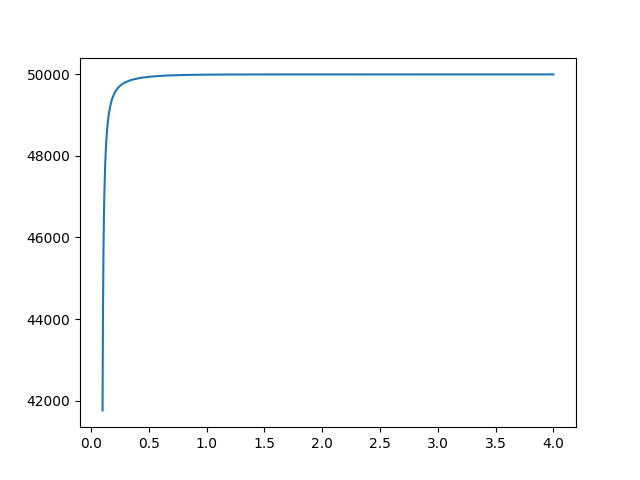

In [111]:
parametrization = LobatoParametrization()

f = open('lobato.json') 
params = json.load(f)
params_scaled = parametrization.scaled_parameters('C', 'potential')
func = lambda r, *args, **kwargs: potential(r, params_scaled, np, *args, **kwargs)

Va = 50000

r, r_m, u, u_m, m_0, v_0, b, x, z = sp.symbols('r r_m u u_m m_0 v b x y')
V = Va - potential(r, params_scaled, sp)
V_u = Va - potential(1/r, params_scaled, sp)

r_xz = sp.sqrt(x ** 2 + z ** 2)
Vxz = Va - potential(r_xz, params_scaled, sp)

dVdx = sp.diff(Vxz, x)
dVdz = sp.diff(Vxz, z)
dVdr = V.diff(r)

V_lambda = sp.lambdify(r, V)
Vu_lambda = sp.lambdify(r, V)
dVdr_lambda = sp.lambdify(r, dVdr)

dVdx_lambda = sp.lambdify([x, z], dVdx)
dVdz_lambda = sp.lambdify([x, z], dVdz)

plt.figure()
plt.plot(np.linspace(0.1, 4, 1000), V_lambda(np.linspace(0.01, 4, 1000)))

In [112]:
vel = np.sqrt(2 * e / m_e * Va) #Initial Velocity (non relativistic)
E0 = 1 / 2 * m_e * (vel) ** 2 / e #Initial Kinetic Energy

bq = hbar / (2 * 1.0 * m_e * vel) * 1e10
print(E0)
print(bq)

bqmin_bmin = (137 * vel) / (1 * 8 * c)

print(bqmin_bmin)

50000.0
0.004364620324927966
7.5756617661118


In [113]:
p = np.linspace(0.01, 15, 3)
dVdr_lambda(p) / p ** 2

print(dVdr_lambda(p) / p ** 2)
print(hbar*vel)

[8.63530787e+09 1.67291665e-11 8.26451256e-25]
1.3985785401762147e-26


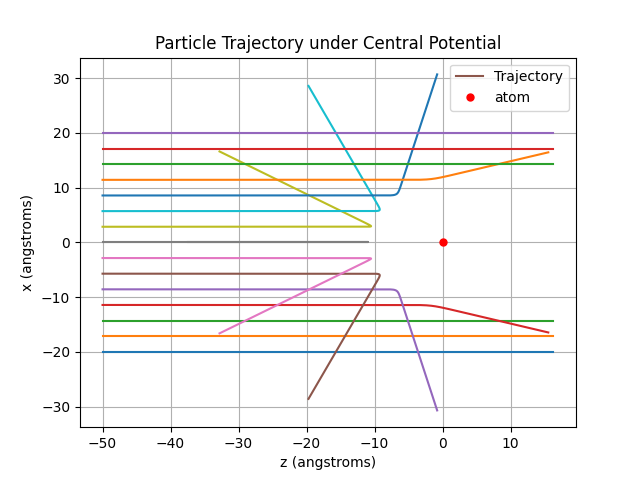

In [123]:
x0s = np.linspace(-20, 20, 15)
fig, ax = plt.subplots()

for x0 in x0s:
    # Initial conditions: [x0, vx0, z0, vz0]
    vx0 = 0  # initial velocity in m/s
    z0 = -50  # initial position in angstroms
    vz0 = vel * 1e-10 # initial velocity in angstrosm/s
    y0 = [x0, vx0, z0, vz0]

    # Time span for the simulation
    t_span = (0, 5000)  # 6000 seconds
    t_eval = np.linspace(t_span[0], t_span[1], 1000)

    # Solve the system of ODEs
    solution = solve_ivp(lorentz_force, t_span, y0, args=[e, m_e, dVdx_lambda, dVdz_lambda], t_eval=t_eval, rtol=1e-8, atol=1e-8)

    # Extract the results
    x_sol = solution.y[0]
    z_sol = solution.y[2]


    ax.plot(z_sol, x_sol, '-')

ax.plot([], [], '-', label="Trajectory")
plt.plot(0, 0, 'or', markersize = 5, label = 'atom')
ax.set_xlabel("z (angstroms)")
ax.set_ylabel("x (angstroms)")
ax.set_title("Particle Trajectory under Central Potential")
plt.legend()
plt.grid()
plt.show()
plt.axis('equal')

In [117]:
# bs = np.linspace(8, 8, 1)

# # Solve for r_minimum - the point of closest approach
# r_ms = np.zeros(len(bs))
# for idx, b in enumerate(bs): 
    
#     l = m_e * b * vel #Initial Angular momentum relative to centre of atom

#     r_min_expr = (l ** 2 / (m_e * r ** 2)) + V - E0 #Expression to minimise to find closest approach (r_min) https://physics.stackexchange.com/questions/701129/closest-approach-as-a-function-of-scattering-potential-and-impact-parameter
#     dr_min_expr = sp.diff(r_min_expr , r) #r_min derivative

#     # Convert sympy expressions to callable functions
#     f = sp.lambdify(r, r_min_expr)
#     df = sp.lambdify(r, dr_min_expr)
    
#     r_ms[idx] = fsolve(f, b, fprime = df, xtol = 1e-4)[0] #Find closest approach position

# print(r_ms)
# u_ms = 1 / r_ms
# u_start = 0.00001
# phi_ms = np.zeros(len(bs))

# for idx, u_m in enumerate(u_ms):
#     b = bs[idx]
#     r_m = r_ms[idx]
    
#     us = np.linspace(0.00001, u_m, 100000)

#     # Solve for phi_m, the angle of closest approach
#     phi = 1 / np.sqrt(1 + (b**2 * (us)**2) - V_lambda(1 / us) / E0)
#     phi_ms[idx] = b * simpson(y = phi, x = us)

# thetas = np.pi - 2 * phi_ms
# print(phi_ms)

In [118]:


# # Create a circle using matplotlib's Circle function
# circle = plt.Circle((0, 0), 1, edgecolor='blue', facecolor='none')

# # Calculating the vector coordinates
# x_vec = r_ms * np.cos(phi_ms)
# y_vec = r_ms * np.sin(phi_ms)

# # Create and add the circle
# circle = plt.Circle((0, 0), np.max(bs), edgecolor='blue', facecolor='none')
# ax.add_patch(circle)

# # Add the vector
# ax.quiver(np.zeros(len(x_vec)), np.zeros(len(x_vec)), x_vec, y_vec, angles='xy', scale_units='xy', scale=1, color='red')

# # Add the circle to the plot
# ax.add_patch(circle)

# # Set the limits and aspect of the plot
# ax.set_xlim(-10, 10)
# ax.set_ylim(0, 10)
# ax.set_aspect('equal', adjustable='box')
# ax.set_title("Circle with Radius 1")
# ax.set_xlabel("x-axis")
# ax.set_ylabel("y-axis")
# ax.grid(True)
